# Analyse de sentiments

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). 

Il y a trois fichiers textes à importer et à concaténer pour former un dataset avec deux colonnes:
- Une "texte" comportant le contenu du commentaire
- Une "sentiment" comportant une note de 0 ou 1

In [1]:
import numpy as np
import pandas as pd

# NLP
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer 
from collections import Counter
import string

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score , accuracy_score, classification_report

from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#import nltk
#nltk.download('popular')

In [2]:
# amazon
amazon = open('sentiment labelled sentences/amazon_cells_labelled.txt').read()

a_sentiment, a_texts = [], []
for i, line in enumerate(amazon.split('\n')):
    content = line.split('\t')
    if len(content) > 1:
        a_texts.append(content[0])
        a_sentiment.append(content[1])

df_a = pd.DataFrame()
df_a['sentiment'] = a_sentiment
df_a['text'] = a_texts
df_a['source'] = 'amazon'

In [3]:
# imdb
imdb = open('sentiment labelled sentences/imdb_labelled.txt').read()

i_sentiment, i_texts = [], []
for i, line in enumerate(imdb.split('\n')):
    content = line.split('\t')
    if len(content) > 1:
        i_texts.append(content[0])
        i_sentiment.append(content[1])

df_i = pd.DataFrame()
df_i['sentiment'] = i_sentiment
df_i['text'] = i_texts
df_i['source'] = 'imdb'

In [4]:
# yelp
yelp = open('sentiment labelled sentences/yelp_labelled.txt').read()

y_sentiment, y_texts = [], []
for i, line in enumerate(yelp.split('\n')):
    content = line.split('\t')
    if len(content) > 1:
        y_texts.append(content[0])
        y_sentiment.append(content[1])

df_y = pd.DataFrame()
df_y['sentiment'] = y_sentiment
df_y['text'] = y_texts
df_y['source'] = 'yelp'

In [5]:
print(df_a.head())
print(df_a.shape)
print()
print(df_i.head())
print(df_i.shape)
print()
print(df_y.head())
print(df_y.shape)

  sentiment                                               text  source
0         0  So there is no way for me to plug it in here i...  amazon
1         1                        Good case, Excellent value.  amazon
2         1                             Great for the jawbone.  amazon
3         0  Tied to charger for conversations lasting more...  amazon
4         1                                  The mic is great.  amazon
(1000, 3)

  sentiment                                               text source
0         0  A very, very, very slow-moving, aimless movie ...   imdb
1         0  Not sure who was more lost - the flat characte...   imdb
2         0  Attempting artiness with black & white and cle...   imdb
3         0       Very little music or anything to speak of.     imdb
4         1  The best scene in the movie was when Gerardo i...   imdb
(1000, 3)

  sentiment                                               text source
0         1                           Wow... Loved this place.

In [6]:
df = pd.concat([df_a, df_i, df_y], ignore_index=True)

In [7]:
df.head()

sentiment                                               text  source
0         0  So there is no way for me to plug it in here i...  amazon
1         1                        Good case, Excellent value.  amazon
2         1                             Great for the jawbone.  amazon
3         0  Tied to charger for conversations lasting more...  amazon
4         1                                  The mic is great.  amazon

In [8]:
df.info()
df['sentiment'] = df['sentiment'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  3000 non-null   object
 1   text       3000 non-null   object
 2   source     3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


#### Questions préalables: 
- Quelle est la taille du dataset ?
- Comment est distribuée la variable sentiment ?


In [9]:
df.shape

(3000, 3)

In [10]:
df.describe()

sentiment
count  3000.000000
mean      0.500000
std       0.500083
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000

In [11]:
df['sentiment'].unique()

array([0, 1])

In [12]:
df['sentiment'].value_counts()

0    1500
1    1500
Name: sentiment, dtype: int64

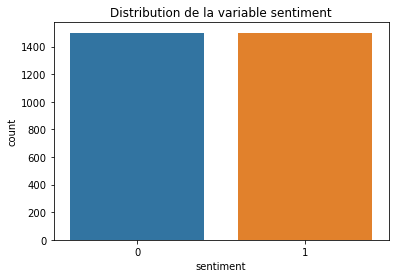

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=df['sentiment'], x=df['sentiment'].index)
plt.title("Distribution de la variable sentiment")
plt.show()

#### Question 1: Combien y a t'il de mots dans l'ensemble du corpus ? Sont-ils "homogènes" ? 


### Import du module permettant le traitement de texte: nltk

#### Consigne 1: Récupérer le corpus de mots sans la ponctuation ni les stopwords

In [86]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Tokenize
    2. Remove all punctuation
    3. Remove all stopwords
    Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english')

    mess = mess.lower()
    # Tokenize text
    tokens = WordPunctTokenizer().tokenize(mess)
    # Lemmatize

    # Remove punctuation
    nopunc = [char for char in tokens if char not in string.punctuation]
    
    # Remove digits
    tokens = [word for word in nopunc if str(word).isalpha()]
    
    # Remove stopwords
    words_without_stopwords = [word for word in tokens if word not in STOPWORDS]

    # Lemmatize
    #lem_word = [WordNetLemmatizer().lemmatize(word) for word in words_without_stopwords]

    # Stem
    #stem = [PorterStemmer().stem(word) for word in lem_word]

    # Return str
    text = ' '.join(words_without_stopwords)

    return text

In [87]:
text_process(df['text'].iloc[0])

'way plug us unless go converter'

In [88]:
df['clean_text'] = ''

In [89]:
df['clean_text'] = df['text'].map(text_process)

In [90]:
df.head()

sentiment                                               text  source  \
0          0  So there is no way for me to plug it in here i...  amazon   
1          1                        Good case, Excellent value.  amazon   
2          1                             Great for the jawbone.  amazon   
3          0  Tied to charger for conversations lasting more...  amazon   
4          1                                  The mic is great.  amazon   

                                          clean_text  words  
0                    way plug us unless go converter      6  
1                          good case excellent value      4  
2                                      great jawbone      2  
3  tied charger conversations lasting minutes maj...      7  
4                                          mic great      2

#### Question 2: Combien de mots restent-ils ? 

In [91]:
df['words'] = df['clean_text'].apply(lambda x: len(x.split()))
df.sample(5)

sentiment                                               text  source  \
2483          0            The selection of food was not the best.    yelp   
817           1     Gets a signal when other Verizon phones won't.  amazon   
1280          0    It was forced, like everything in this movie.      imdb   
2642          1  Our waiter was very attentive, friendly, and i...    yelp   
109           0  I purcashed this for the car charger and it do...  amazon   

                                 clean_text  words  
2483                    selection food best      3  
817              gets signal verizon phones      4  
1280           forced like everything movie      4  
2642  waiter attentive friendly informative      4  
109              purcashed car charger work      4

In [92]:
df['words'].sum()

18014

In [93]:
len_txt_unique = set(df['clean_text'])
print(len(len_txt_unique))

2915


## Exercice 1 : approche td-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*.

#### Consigne 2: Utiliser OneHotEncoder ou CountVectorizer pour représenter les données sous forme d'une matrice contenant autant de colonnes que de mots dans le corpus

In [94]:
ohs = OneHotEncoder()
enc =ohs.fit_transform(np.array(df['clean_text']).reshape(1,-1))
enc.toarray()

array([[1., 1., 1., ..., 1., 1., 1.]])

In [110]:
vec =CountVectorizer(analyzer='word', token_pattern=r'\w{1,}') 
X = vec.fit_transform(df['clean_text'])
pd.DataFrame(X.toarray(),columns=vec.get_feature_names_out(), index=df.index)

aailiyah  abandoned  abhor  ability  able  abound  abroad  absolute  \
0            0          0      0        0     0       0       0         0   
1            0          0      0        0     0       0       0         0   
2            0          0      0        0     0       0       0         0   
3            0          0      0        0     0       0       0         0   
4            0          0      0        0     0       0       0         0   
...        ...        ...    ...      ...   ...     ...     ...       ...   
2995         0          0      0        0     0       0       0         0   
2996         0          0      0        0     0       0       0         0   
2997         0          0      0        0     0       0       0         0   
2998         0          0      0        0     0       0       0         0   
2999         0          0      0        0     0       0       0         0   

      absolutel  absolutely  ...  yucky  yukon  yum  yummy  yun  z  zero  \
0             0           0  ...      0      0    0      0    0  0     0   
1             0           0  ...      0      0    0      0    0  0     0   
2             0           0  ...      0      0    0      0    0  0     0   
3             0           0  ...      0      0    0      0    0  0     0   
4             0           0  ...      0      0    0      0    0  0     0   
...         ...         ...  ...    ...    ...  ...    ...  ... ..   ...   
2995          0           0  ...      0      0    0      0    0  0     0   
2996          0           0  ...      0      0    0      0    0  0     0   
2997          0           0  ...      0      0    0      0    0  0     0   
2998          0           0  ...      0      0    0      0    0  0     0   
2999          0           0  ...      0      0    0      0    0  0     0   

      zillion  zombie  zombiez  
0           0       0        0  
1           0       0        0  
2           0       0        0  
3           0       0        0  
4           0       0        0  
...       ...     ...      ...  
2995        0       0        0  
2996        0       0        0  
2997        0       0        0  
2998        0       0        0  
2999        0       0        0  

[3000 rows x 4937 columns]

In [96]:
print(*vec.get_feature_names_out()[:100])

aailiyah abandoned abhor ability able abound abroad absolute absolutel absolutely absolutley abstruse abysmal ac academy accents accept acceptable access accessable accessible accessing accessory accessoryone accident accidentally acclaimed accolades accommodations accomodate accompanied according accordingly accountant accurate accurately accused ache achievement achille ackerman acknowledged across act acted acting action actions activate activated activesync actor actors actress actresses actual actually ad adams adaptation adapter adapters add added addition additional address adhesive admins admiration admitted adorable adrift adventure advertised advise aerial aesthetically affected affleck affordable afraid africa afternoon age aged ages aggravating ago agree agreed ahead aimless air aired airline airport akasha akin ala


In [97]:
np.shape(X.todense())

(3000, 4937)

#### Consigne 3: lancer un modèle de classification pour prédire les sentiments de 30% des observations



*   Séparer échantillon train / test
*   Entrainer un modèle de classification
*   Afficher la matrice de confusion
*   Calculer l'accuracy, la précision et le recall
*   Votre modèle est-il soumis à un overfitting ?

In [111]:
y = df['sentiment']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)

In [113]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [114]:
print(f"Score: {score}")
print(f"Accuracy: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall {recall}')

Score: 0.8122222222222222
Accuracy: 0.8122222222222222
Precision: 0.8105726872246696
Recall 0.8159645232815964


In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       449
           1       0.81      0.82      0.81       451

    accuracy                           0.81       900
   macro avg       0.81      0.81      0.81       900
weighted avg       0.81      0.81      0.81       900



### logistic reg

In [116]:
td = TfidfVectorizer()
X = td.fit_transform(df['clean_text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)

In [117]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [118]:
print(f"Score: {score}")
print(f"Accuracy: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall {recall}')

Score: 0.7977777777777778
Accuracy: 0.7977777777777778
Precision: 0.8240963855421687
Recall 0.7583148558758315


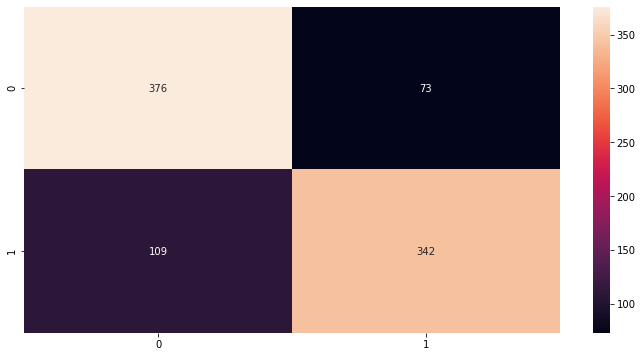

In [119]:
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, annot=True,fmt='d')
plt.show()

In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       449
           1       0.82      0.76      0.79       451

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg       0.80      0.80      0.80       900



#### Consigne 4: Utiliser TF-IDF pour représenter les données et relancer un modèle de classification

In [121]:

td = TfidfVectorizer()
X = td.fit_transform(df['clean_text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)

In [122]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [123]:
print(f"Score: {score}")
print(f"Accuracy: {accuracy}")
print(f'Precision: {precision}')
print(f'Recall {recall}')

Score: 0.8211111111111111
Accuracy: 0.8211111111111111
Precision: 0.8008298755186722
Recall 0.8558758314855875


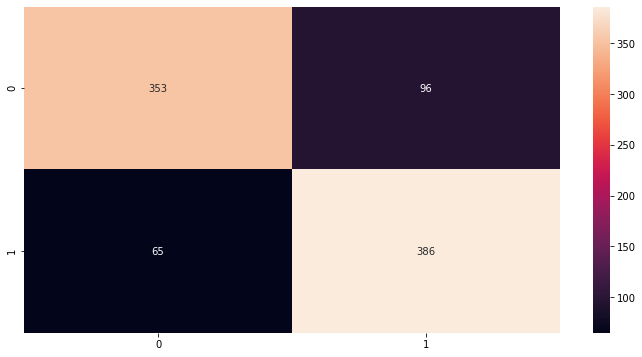

In [124]:
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, annot=True,fmt='d')
plt.show()

In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       449
           1       0.80      0.86      0.83       451

    accuracy                           0.82       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.82      0.82      0.82       900



In [126]:
ind = (y_pred == y_test).where((y_pred == y_test) == False).dropna().index

In [148]:
list(df.iloc[ind]['clean_text'])

['leave theater wanting go dance stars',
 'would recommend place',
 'liked way dustin hoffman character ready everything stay son',
 'last night second time dining happy decided go back',
 'would even good made tv flick',
 'rest movie lacks art charm meaning emptiness works guess empty',
 'bought hoping could make bluetooth headset fit better things made impossible wear',
 'buy different phone',
 'failed convey broad sweep landscapes great part original',
 'terribly disappointed film would receive many awards accolades especially far deserving works film',
 'design odd ear clip comfortable',
 'first time going think quickly become regular',
 'much dialogue much music whole film shot elaborately aesthetically like sculpture',
 'buy want use holster',
 'seafood limited boiled shrimp crab legs crab legs definitely taste fresh',
 'internet access fine rare instance worked',
 'crust good',
 'spoilers whatever else said surface superbly crafted',
 'perhaps caught night judging reviews inspir

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity).

#### Consigne 5: Utiliser Word2vec pour représenter les données et relancer un modèle de classification

In [128]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [129]:
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [156]:
dfword2vec=df.copy()
dfword2vec.head()

sentiment                                               text  source  \
0          0  So there is no way for me to plug it in here i...  amazon   
1          1                        Good case, Excellent value.  amazon   
2          1                             Great for the jawbone.  amazon   
3          0  Tied to charger for conversations lasting more...  amazon   
4          1                                  The mic is great.  amazon   

                                          clean_text  words  
0                    way plug us unless go converter      6  
1                          good case excellent value      4  
2                                      great jawbone      2  
3  tied charger conversations lasting minutes maj...      7  
4                                          mic great      2

In [159]:
for i in range(dfword2vec.shape[0]):
    dfword2vec['clean_text'][i]=dfword2vec['clean_text'][i].split(' ')
dfword2vec.head()

<ipython-input-159-a1196c8f869e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfword2vec['clean_text'][i]=dfword2vec['clean_text'][i].split(' ')


sentiment                                               text  source  \
0          0  So there is no way for me to plug it in here i...  amazon   
1          1                        Good case, Excellent value.  amazon   
2          1                             Great for the jawbone.  amazon   
3          0  Tied to charger for conversations lasting more...  amazon   
4          1                                  The mic is great.  amazon   

                                          clean_text  words  
0             [way, plug, us, unless, go, converter]      6  
1                     [good, case, excellent, value]      4  
2                                   [great, jawbone]      2  
3  [tied, charger, conversations, lasting, minute...      7  
4                                       [mic, great]      2

In [160]:
model = Word2Vec(sentences=dfword2vec['clean_text'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

2022-02-28 16:54:12,870 : INFO : collecting all words and their counts
2022-02-28 16:54:12,872 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-28 16:54:12,882 : INFO : collected 4938 word types from a corpus of 18017 raw words and 3000 sentences
2022-02-28 16:54:12,884 : INFO : Creating a fresh vocabulary
2022-02-28 16:54:12,938 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 4938 unique words (100.0%% of original 4938, drops 0)', 'datetime': '2022-02-28T16:54:12.938707', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2022-02-28 16:54:12,939 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 18017 word corpus (100.0%% of original 18017, drops 0)', 'datetime': '2022-02-28T16:54:12.939705', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'pl

In [161]:
model.predict_output_word('texture')

[('phone', 0.00020253667),
 ('good', 0.00020253385),
 ('place', 0.00020253158),
 ('would', 0.00020253152),
 ('great', 0.0002025313),
 ('film', 0.0002025306),
 ('service', 0.00020252586),
 ('excellent', 0.00020252561),
 ('definitely', 0.00020252558),
 ('love', 0.00020252513)]

In [162]:
X = dfword2vec['clean_text']
y = dfword2vec['sentiment']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Exercice 3 : Comparer les deux approches

#### Consigne 6: Faire un graphique montrant les courbes ROC associées au deux modèles

#### Consigne 7: Faire un graphique montrant les courbes Precision-Recall associées aux deux modèles

### BONUS: reprendre l'étape de One_hot_encoding et ajouter une étape de réduction de dimension (type ACP)